In [1]:
# 功能模組
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 解決 plot中文問題
plt.rcParams['axes.unicode_minus'] = False

In [2]:
#TEJ API
import tejapi
tejapi.ApiConfig.api_key = "YOUR KEY"

In [3]:
industry = tejapi.get("TWN/AIND",
                      paginate=True,
                      opts={'columns':['coid','mdate','mkt','tejinm4_c','tejinm3_c']},
                      chinese_column_name=True)

industry = industry[~industry['TSE新產業_名稱'].isin(['金融業','','存託憑證']) &
                    (industry['上市別'].isin(['TSE','OTC']))]

security_list = industry['公司簡稱'].tolist()

In [4]:
# TEJ為維持主機運行的穩定，總筆數單次最多為1,000,000筆。故我們可以將公司以50家分一組，以便迴圈分次撈取資料
groups = []
while True:
    if len(security_list) >= 50:
        groups.append(security_list[:50])
        security_list = security_list[50:]
    elif 0 <= len(security_list) < 50:
        groups.append(security_list)
        break

market_value = pd.DataFrame()
for group in groups:
    market_value = market_value.append(tejapi.get('TWN/APRCD',
                                                  coid = group,
                                                  mdate= {'gte': '2015-01-01','lte':'2021-01-19'},
                                                  opts={'columns':['coid','mdate','mv']},
                                                  chinese_column_name=True,paginate=True)).reset_index(drop=True)
        
data = pd.DataFrame()
for group in groups:
    data = data.append(tejapi.get('TWN/ATINST1',
                       coid = group,
                       mdate= {'gte': '2015-01-01','lte':'2021-01-19'},
                       opts={'columns':['coid','mdate','qfiimv','fundmv','dlrmv']},
                       chinese_column_name=True,paginate=True)).reset_index(drop=True)

In [6]:
data = pd.merge(data,industry, how='left', left_on='證券名稱', right_on='公司簡稱')
data = pd.merge(data,market_value, how='left', left_on=['證券名稱','年月日'], right_on=['證券代碼','年月日'])
data.head(10)

,證券名稱,年月日,外資總投資市值(百萬),投信持股數市值(百萬),自營持股數市值(百萬),公司簡稱,目前狀態,上市別,TSE新產業_名稱,TEJ子產業_名稱,證券代碼,市值(百萬元)
0,1101,2015-01-05 00:00:00+00:00,56871.71,1962.35,41.97,1101,2022-01-01 00:00:00+00:00,TSE,水泥工業,水泥製造,1101,158764.0
1,1101,2015-01-06 00:00:00+00:00,55778.62,1928.12,35.70,1101,2022-01-01 00:00:00+00:00,TSE,水泥工業,水泥製造,1101,155994.0
2,1101,2015-01-07 00:00:00+00:00,55353.92,1923.89,17.89,1101,2022-01-01 00:00:00+00:00,TSE,水泥工業,水泥製造,1101,155441.0
3,1101,2015-01-08 00:00:00+00:00,55364.61,1899.05,19.82,1101,2022-01-01 00:00:00+00:00,TSE,水泥工業,水泥製造,1101,155994.0
4,1101,2015-01-09 00:00:00+00:00,54454.62,1872.85,12.16,1101,2022-01-01 00:00:00+00:00,TSE,水泥工業,水泥製造,1101,154333.0
5,1101,2015-01-12 00:00:00+00:00,52691.95,1763.78,3.91,1101,2022-01-01 00:00:00+00:00,TSE,水泥工業,水泥製造,1101,150456.0
6,1101,2015-01-13 00:00:00+00:00,53339.45,1794.44,6.32,1101,2022-01-01 00:00:00+00:00,TSE,水泥工業,水泥製造,1101,152487.0
7,1101,2015-01-14 00:00:00+00:00,53150.09,1790.56,4.38,1101,2022-01-01 00:00:00+00:00,TSE,水泥工業,水泥製造,1101,152487.0
8,1101,2015-01-15 00:00:00+00:00,53192.83,1799.55,6.30,1101,2022-01-01 00:00:00+00:00,TSE,水泥工業,水泥製造,1101,153041.0
9,1101,2015-01-16 00:00:00+00:00,52841.37,1799.55,2.90,1101,2022-01-01 00:00:00+00:00,TSE,水泥工業,水泥製造,1101,153041.0


In [7]:
# 計算籌碼持股市值
data['其他(百萬元)'] = data['市值(百萬元)'] - data['外資總投資市值(百萬)'] - data['投信持股數市值(百萬)'] \
    - data['自營持股數市值(百萬)']

data = data[['證券代碼','TSE新產業_名稱', 'TEJ子產業_名稱', '年月日', '外資總投資市值(百萬)',
             '投信持股數市值(百萬)', '自營持股數市值(百萬)','其他(百萬元)']]

data = data.rename(columns={'外資總投資市值(百萬)':'外資',
                           '投信持股數市值(百萬)':'投信',
                           '自營持股數市值(百萬)':'自營',
                           '其他(百萬元)':'其他'})

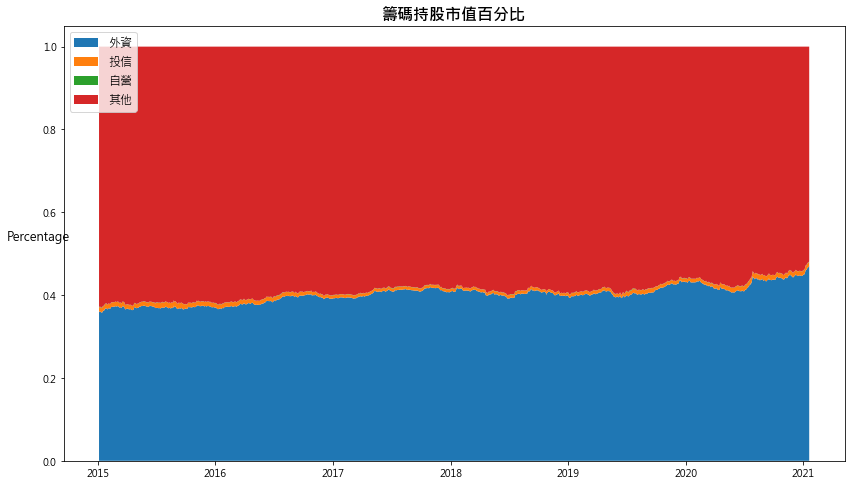

In [8]:
# 繪製籌碼持股市值百分比
figure_table1 = data.groupby(['年月日'])[['外資','投信', '自營','其他']].sum()
figure_table1 = figure_table1.divide(figure_table1.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize = (14,8))
ax.set_title('籌碼持股市值百分比', fontsize=16, fontweight='bold')
ax.set_ylabel('Percentage', fontsize=12,rotation=0)
ax = ax.stackplot(figure_table1.index, figure_table1.T)
plt.legend(figure_table1.columns,loc=2, prop={'size': 12})
plt.show()

# 要反過來看圖例去對照圖形

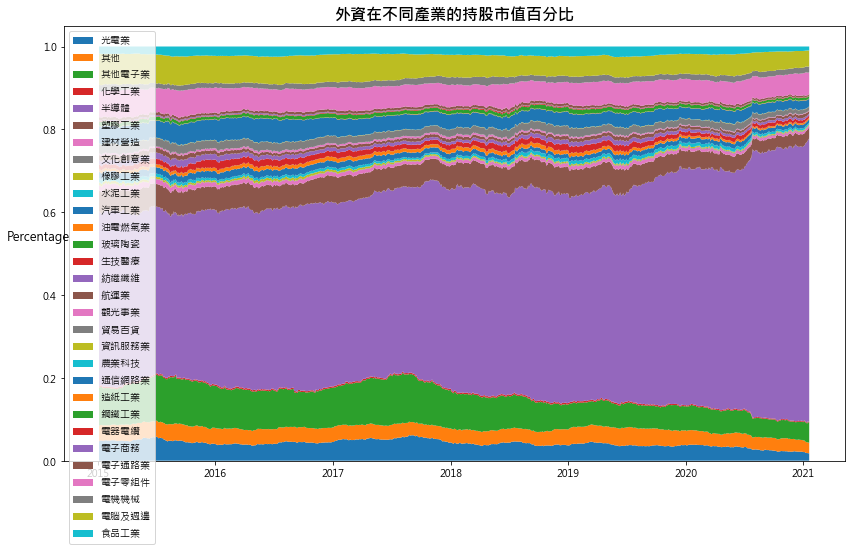

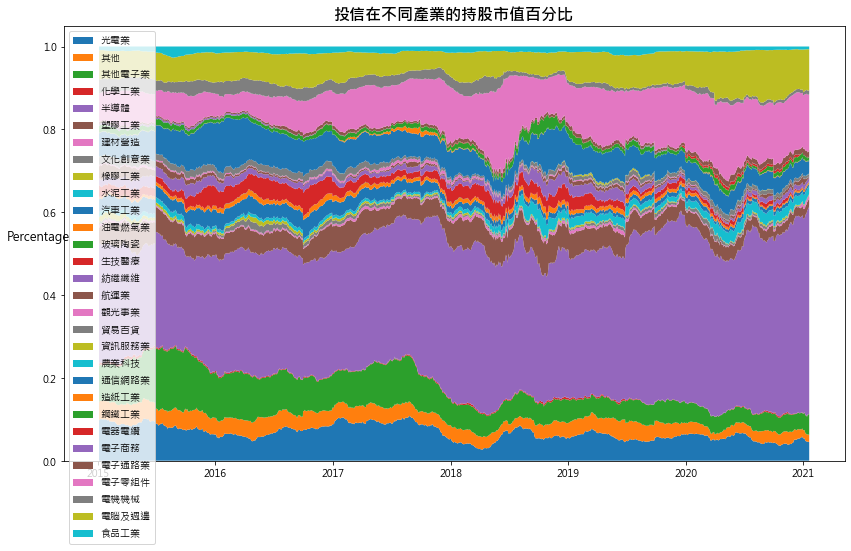

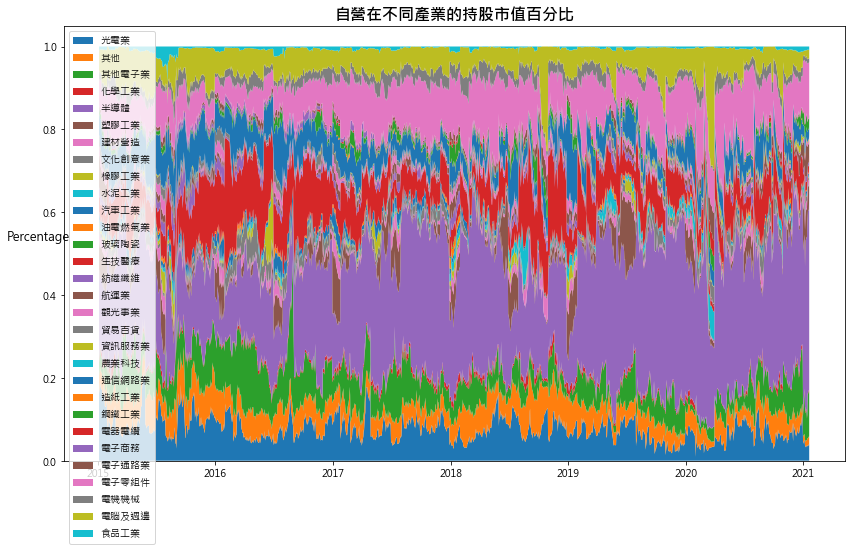

In [9]:
# 繪製不同產業的籌碼持股市值百分比
for i in ['外資','投信','自營']:
    figure_table2 = data.groupby(['年月日','TSE新產業_名稱'])[i].sum().reset_index()
    figure_table2 = figure_table2.pivot(index='年月日',columns='TSE新產業_名稱', values=i)
    figure_table2 = figure_table2.divide(figure_table2.sum(axis=1), axis=0)
    
    fig, ax = plt.subplots(figsize = (14,8))
    ax.set_title(i + '在不同產業的持股市值百分比', fontsize=16, fontweight='bold')
    ax.set_ylabel('Percentage', fontsize=12,rotation=0)
    ax = ax.stackplot(figure_table2.index, figure_table2.T)
    plt.legend(figure_table2.columns,loc=2, prop={'size': 10})
    plt.show()
    
# 要反過來看圖例去對照圖形

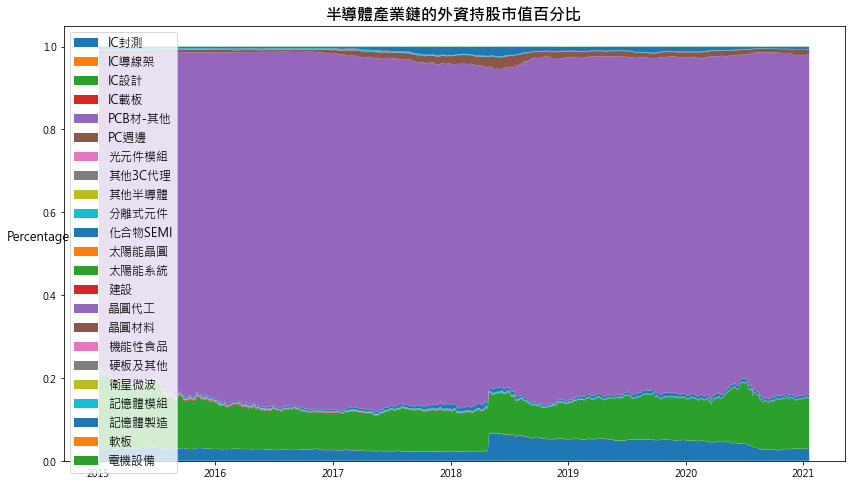

In [10]:
# 繪製半導體產業鏈的外資持股市值百分比
figure_table3 = data[data['TSE新產業_名稱'] == '半導體']
figure_table3 = figure_table3.groupby(['年月日','TEJ子產業_名稱'])['外資'].sum()
figure_table3 = figure_table3.reset_index()
figure_table3 = figure_table3.pivot(index='年月日',columns='TEJ子產業_名稱', values='外資')
figure_table3 = figure_table3.fillna(0)
figure_table3 = figure_table3.divide(figure_table3.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize = (14,8))
ax.set_title('半導體產業鏈的外資持股市值百分比', fontsize=16, fontweight='bold')
ax.set_ylabel('Percentage', fontsize=12,rotation=0)
ax = ax.stackplot(figure_table3.index, figure_table3.T)
plt.legend(figure_table3.columns,loc=2, prop={'size': 12})
plt.show()

# 要反過來看圖例去對照圖形

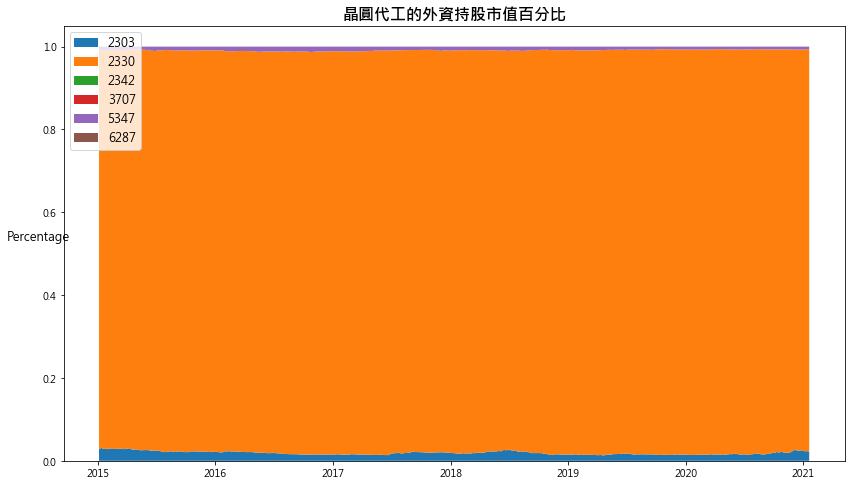

In [11]:
# 繪製晶圓代工的外資持股市值百分比
figure_table4 = data[(data['TSE新產業_名稱'] == '半導體') & (data['TEJ子產業_名稱'] == '晶圓代工')]
figure_table4 = figure_table4.groupby(['年月日','證券代碼'])['外資'].sum()
figure_table4 = figure_table4.reset_index()
figure_table4 = figure_table4.pivot(index='年月日',columns='證券代碼', values='外資')
figure_table4 = figure_table4.divide(figure_table4.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize = (14,8))
ax.set_title('晶圓代工的外資持股市值百分比', fontsize=16, fontweight='bold')
ax.set_ylabel('Percentage', fontsize=12,rotation=0)
ax = ax.stackplot(figure_table4.index, figure_table4.T)
plt.legend(figure_table4.columns,loc=2, prop={'size': 12})
plt.show()

# 要反過來看圖例去對照圖形